## Notebook to code up method of moments framework 

Here, I will use the method of moments framework used to track the trajectory of the site frequency spectrum through time given drift and selection from [Jouganous et. al. 2017](https://www.genetics.org/content/206/3/1549). Mostly, I will just use equations to start from a certain generation $t$ back in time and then iterate until generation 0. Then I will store this SFS as a data entry for allele age $t$ and certain selection coefficient $s$. This process will be repeated for each value of $\{1,\ldots,gen,\ldots,12000\}$ generations. 

These vectors need to be summed to marginalize over *all* generations $a$, to give $P(X, a | s)$.

First, need to get a handle on what $\Phi_n^k(i)$ really is - can just be represented as *np.array*

$\phi_n^k(i)$ is the expected number of sites where the alternate allele is observed exactly $i$ times in a sample of size $n$ at generation $k$. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from copy import deepcopy
import matplotlib.colors as colors
from scipy.sparse import coo_matrix
import moments

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams.update({"figure.facecolor": "white"})


In [178]:
N = 5000
# gamma = -np.exp(np.linspace(np.log(0.02),np.log(50),25))
s = -25/N # 25/N -> gamma = 50 - strong selection
mu = 1.25e-8 # human mutation rate
n = 100 # 2 * # of inds sampled, diploid

# start in generation 10 so generation 11 has all zeros (going back in time)
tot_gen = 10000
time_steps = np.linspace(0, tot_gen-1, 100, dtype=int)

mom = np.zeros((tot_gen+1,n+1))
momnp1 = np.zeros(n+1)
momkp1 = np.zeros((tot_gen+1,n+1))

# double precaution - creating a mask
mk = [False] + [True]*(n-1) + [False]

iter = np.arange(1,n)
iterm1p1 = np.arange(2,n-1)

In [177]:
np.linspace(10,1,dtype=int)

array([10,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,
        6,  6,  6,  6,  6,  5,  5,  5,  5,  5,  5,  4,  4,  4,  4,  4,  3,
        3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1])

In [5]:
## borrowed directly from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx
def python2round(f):
    if round(f + 1) - round(f) != 1:
        return f + abs(f) / f * 0.5
    return round(f)

# The choice i' in n samples that best approximates the frequency of i/(n + 1) is i*n / (n + 1)
def index_bis(i, n):
    return int(min(max(python2round(i * n / float(n+1)), 2), n-2))

In [43]:
# code borrowed from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx  
def calcJK13(n):
    J = np.zeros((n,n-1))
    for i in range(n):
        ibis = index_bis(i + 1, n) - 1
        J[i, ibis] = -(1.+n) * ((2.+i)*(2.+n)*(-6.-n+(i+1.)*(3.+n))-2.*(4.+n)*(-1.+(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n)
        J[i, ibis - 1] = (1.+n) * (4.+(1.+i)**2*(6.+5.*n+n**2)-(i+1.)*(14.+9.*n+n**2)-(4.+n)*(-5.-n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
        J[i, ibis + 1] = (1.+n) * ((2.+i)*(2.+n)*(-2.+(i+1.)*(3.+n))-(4.+n)*(1.+n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
    return J

In [179]:
## testbed for a single realization of gen = t
mom[tot_gen,1] = n*1 # singleton input

# going from generation 9 to 0
for gen in np.arange(tot_gen)[::-1]:
    momkp1[gen,iterm1p1] = 0.25/N * (mom[gen+1,iterm1p1-1] * (iterm1p1-1)*(n-iterm1p1+1) + mom[gen+1,iterm1p1+1] * (iterm1p1+1)*(n-iterm1p1-1) - mom[gen+1,iterm1p1] * 2*iterm1p1*(n-iterm1p1))

    momkp1[gen,1] = 0.25/N * ((n-2) * 2 * mom[gen+1,2] - 2 * (n-1) * mom[gen+1,1])
    momkp1[gen,n-1] = 0.25/N * ((n-2) * 2 * mom[gen+1,n-2] - 2 * (n-1) * mom[gen+1,n-1])

    # notice the difference in indexing for LHS
    # momnp1[np.arange(1,n+1)] = (jk13[:,0] * mom[gen+1,np.array(ibis)-1] - jk13[:,1] * mom[gen+1,np.array(ibis)] + jk13[:,2] * mom[gen+1,np.array(ibis)+1])
    momnp1[np.arange(1,n+1)] = (J @ mom[gen+1,iter])

    # restricting SFS to positive entries 
    # momnp1.clip(min=0.0, out=momnp1)
    # momnp1[momnp1<0] = 0.0

    momkp1[gen,iter] += mom[gen+1,iter] + 0.5 * s/(n+1) * (iter * (n+1-iter) * momnp1[iter] - (n-iter) * (iter+1) * momnp1[iter+1])

    mom[gen,] = deepcopy(momkp1[gen,])

mom2 = deepcopy(mom)

IndexError: index 10000 is out of bounds for axis 0 with size 101

In [127]:
## code to run APR's moments and compare with output from above
# initialize the spectrum, with 1 in singleton bin
fs = moments.Spectrum(np.zeros(2*n + 1))
fs[1] = n*1
# simulate a generations
T = tot_gen / 2 / N
# set relative size to 1, theta to 0 to forbid new mutations
fs.integrate([1], T, gamma=s*2*N, h=0.5, theta=0, adapt_dt=True, dt_fac=0.005)

In [128]:
# fs.integrate([1], 0.01*T, gamma=s*2*N, theta=0, h=0.5)
fs = fs.project([n]) * 2

Text(0, 0.5, 'iterate')

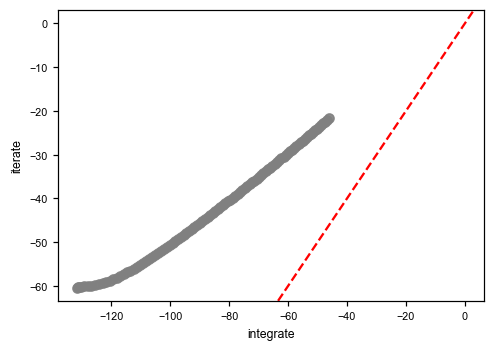

In [129]:
plt.scatter(np.log(np.abs(fs)), np.log(np.abs(mom[0,:])), color='grey', alpha=0.9)
plt.axline((0,0),slope=1,color='red',ls='--'); plt.xlabel('integrate'); plt.ylabel('iterate')

In [293]:
# for dt in 
fsmat = np.zeros((100,n+1))
for idt, dt in enumerate(np.linspace(1e-3*T,T,100)[::-1]):
    fs = moments.Spectrum(np.zeros(n + 1))
    fs[1] = n*1
    fs.integrate([1], dt, gamma=0.5*s*2*N, h=0.5, theta=0, adapt_dt=True)
    fsmat[idt,:] = mu*fs

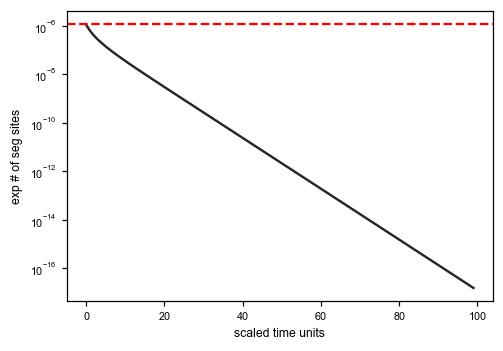

In [297]:
plt.plot(range(100)[::-1],np.sum(fsmat[:,1:100],axis=1),color='black',alpha=1)
plt.plot(range(100)[::-1],np.sum(mom2[time_steps,1:100],axis=1),color='grey',alpha=0.3)
plt.semilogy(); plt.xlabel('scaled time units'); plt.ylabel('exp # of seg sites')
plt.axhline(n*mu, color='red', ls='--',label='sample scaled mutation rate')

Text(0, 0.5, 'scaled time units')

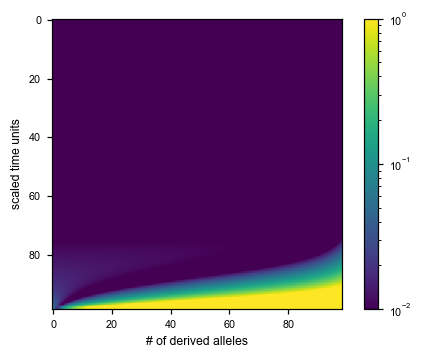

In [299]:
# np.sum(fsmat[:,1:],axis=1)
plt.imshow(np.abs(fsmat[:-1,1:100]-mom2[time_steps[:-1],1:100])/mom2[time_steps[:-1],1:100],norm=colors.LogNorm(vmax=1,vmin=1e-2))
# plt.imshow(np.abs(fsmat[:-1,1:100]-mom2[time_steps[:-1],1:100]),norm=colors.LogNorm(vmin=1e-20))
plt.colorbar(); plt.xlabel('# of derived alleles'); plt.ylabel('scaled time units')

(array([9.791e+03, 4.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([2.62853296e-78, 1.14374780e-09, 2.28749559e-09, 3.43124339e-09,
        4.57499118e-09, 5.71873898e-09, 6.86248677e-09, 8.00623457e-09,
        9.14998236e-09, 1.02937302e-08, 1.14374780e-08, 1.25812257e-08,
        1.37249735e-08, 1.48687213e-08, 1.60124691e-08, 1.71562169e-08,
        1.82999647e-08, 1.94437125e-08, 2.05874603e-08, 2.17312081e-08,
        2.28749559e-08, 2.40187037e-08, 2.51624515e-08, 2.63061993e-08,
        2.74499471e-08, 2.85936949e-08]),
 <BarContainer object of 25 artists>)

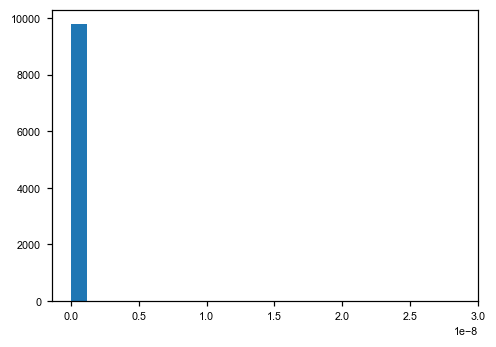

In [301]:
# np.where(np.max(np.abs(fsmat[:,1:100]-mom2[time_steps,1:100])))
# mom2[time_steps,2]
plt.hist(np.ravel(np.abs(fsmat[:-1,1:100]-mom2[time_steps[:-1],1:100])),25)

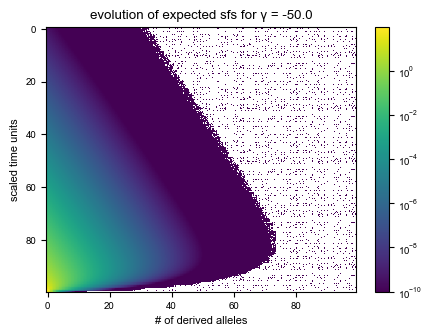

In [197]:
plt.figure(dpi=100)
plt.imshow((fsmat[-100:,1:]),aspect='auto',norm=colors.LogNorm(vmin=1e-10))
plt.xlabel('# of derived alleles'); plt.ylabel('scaled time units'); plt.title('evolution of expected sfs for γ = {}'.format(s*2*N))
plt.colorbar(); plt.show()

In [104]:
J = calcJK13(n)
S = 0.5 * s * calcS(n+1, J)
D = 0.25/N * calcD(n+1)

In [1194]:
## testbed for a single realization of gen = t
mom[tot_gen,1] = n*1 # singleton input

# going from generation 9 to 0
for gen in np.arange(tot_gen)[::-1]:

    momkp1[gen,iter] = mom[gen+1,iter] + ((D[iter,] + S[iter,]) @ mom[gen+1,])
    # momkp1[gen,0] = momkp1[gen,n] = 0.0

    mom[gen,] = deepcopy(momkp1[gen,])

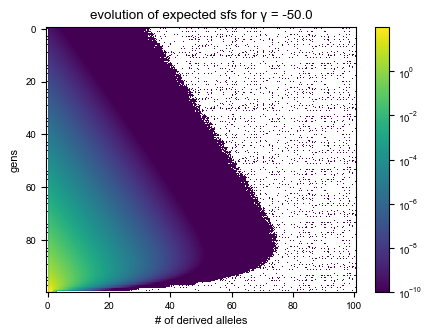

In [196]:
plt.figure(dpi=100)
plt.imshow((mom2[time_steps,:]),aspect='auto',norm=colors.LogNorm(vmin=1e-10))
plt.xlabel('# of derived alleles'); plt.ylabel('gens'); plt.title('evolution of expected sfs for γ = {}'.format(s*2*N))
plt.colorbar(); plt.show()

# plt.figure(dpi=100)
# plt.imshow((mom[-10000:,:]),aspect='auto',norm=colors.LogNorm(vmax=1,vmin=1e-10))
# plt.xlabel('# of derived alleles'); plt.ylabel('gens'); plt.title('evolution of expected sfs for γ = {}'.format(s*2*N))
# plt.colorbar(); plt.show()

# plt.figure(dpi=90)
# plt.scatter(np.arange(tot_gen+1)[::-1][-100000:],(np.sum(mom[-100000:,:],axis=1)),alpha=0.7,color='k')
# plt.loglog(); plt.xlabel('gens'); plt.ylabel('exp # of seg sites')
# plt.axhline(n*1, color='red', ls='--',label='sample scaled mutation rate')
# plt.axvline(0.5*N, color='grey',label='N/2'); plt.legend()
# plt.axvline(tot_gen-np.max(np.where(np.sum(mom,axis=1)<0)), color='coral', ls='-.')

In [191]:
mom2[:,1]

array([3.81832893e-10, 3.82749980e-10, 3.83669269e-10, ...,
       9.75437953e+01, 9.87605491e+01, 1.00000000e+02])

Text(0, 0.5, 'expected SFS')

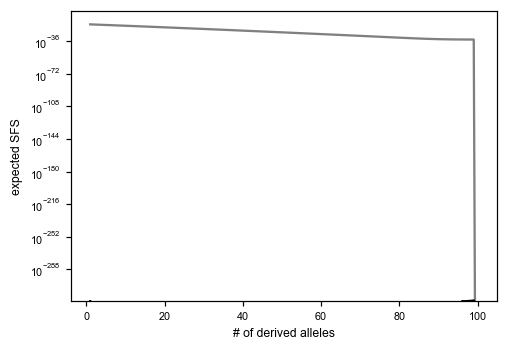

In [153]:
# plt.hist(np.ravel(mom[8000:10000,30:]))
plt.plot(np.arange(1,n+1),mu*mom[0,1:],color='grey',label='iterate')
plt.plot(np.arange(1,n+1),fs[1:],color='black',label='integrate')
plt.semilogy(); plt.xlabel('# of derived alleles'); plt.ylabel('expected SFS')
# plt.scatter(np.ravel(mom),np.ravel(mom2),alpha=0.5,color='grey'); plt.axline((0,0),(1,1),color='red')

In [9]:
def calcD(d):
    res = np.zeros([d, d])
    # loop over the fs elements:
    for i in range(d):
        if i > 1:
            res[i, i - 1] = (i-1) * (d-i)
        if i < d - 2:
            res[i, i + 1] = (i+1) * (d-i-2)
        if i > 0 and i < d - 1:
            res[i, i] = -2 * i * (d-i-1)
    return res

In [10]:
def calcS(d, ljk):
    # Computes the jackknife-transformed selection matrix 1
    # for the addition of a single sample
    # arrays for the creation of the sparse (coo) matrix
    # data will have matrix entry, row + column have coordinates
    data = []
    row = []
    col = []
    # loop over the fs elements:
    for i in range(d):
        i_bis = index_bis(i, d - 1) # This picks the second jackknife index 
        i_ter = index_bis(i + 1, d - 1) # This picks the third jackknife index
        # coefficients of the selection matrix
        g1 = i * (d-i) / np.float64(d)
        g2 = -(i+1) * (d-1-i) / np.float64(d)

        if i < d - 1 and i > 0: # First deal with non-fixed variants
            data += [g1 * ljk[i - 1, i_bis - 1], g1 * ljk[i - 1, i_bis - 2],
                    g1 * ljk[i - 1, i_bis], g2 * ljk[i, i_ter - 1],
                    g2 * ljk[i, i_ter - 2], g2 * ljk[i, i_ter]]
            row += 6 * [i]
            col += [i_bis, i_bis - 1, i_bis + 1,
                    i_ter, i_ter - 1, i_ter + 1]
        
        elif i == 0: # g1=0
            data += [g2 * ljk[i, i_ter - 1],
                     g2 * ljk[i, i_ter - 2], g2 * ljk[i, i_ter]]
            row += 3 * [i]
            col += [i_ter, i_ter - 1, i_ter + 1]
        
        elif i == d - 1: # g2=0
            data += [g1 * ljk[i - 1, i_bis - 1], g1 * ljk[i - 1, i_bis - 2],
                     g1 * ljk[i - 1, i_bis]]
            row += 3 * [i]
            col += [i_bis, i_bis - 1, i_bis + 1]

    return coo_matrix((data, (row, col)), shape=(d, d), dtype='float').tocsc()

In [176]:
## packaging into a function for easy manipulation 
# input: t (number of gens), n (number of samples), s, N (pop size)
# output: mom (gen x number of sites)
# 
def run_mom_framework(t, n, s, N, misc):
    mom = np.zeros((t+1,n+1))
    momnp1 = np.zeros(n+1)
    momkp1 = np.zeros(n+1)

    iter = np.arange(1,n)
    iterm1p1 = np.arange(2,n-1)

    mom[t,1] = n*mu # singleton input

    ibis = misc[0]
    jk13 = misc[1]

    # going from generation 9 to 0
    for gen in np.arange(t)[::-1]:
        momkp1[iterm1p1] = mom[gen+1,iterm1p1-1] * (iterm1p1-1)*(n-iterm1p1+1) + mom[gen+1,iterm1p1+1] * (iterm1p1+1)*(n-iterm1p1-1) - mom[gen+1,iterm1p1] * 2*iterm1p1*(n-iterm1p1)

        momkp1[1] = (n-2) * 2 * mom[gen+1,2] - 2 * (n-1) * mom[gen+1,1]
        momkp1[n-1] = (n-2) * 2 * mom[gen+1,n-2] - 2 * (n-1) * mom[gen+1,n-1]

        # notice the difference in indexing for LHS
        momnp1[np.arange(1,n+1)] = jk13[:,0] * mom[gen+1,np.array(ibis)-1] + jk13[:,1] * mom[gen+1,np.array(ibis)] + jk13[:,2] * mom[gen+1,np.array(ibis)+1]

        momkp1[iter] = mom[gen+1,iter] + 0.5 * s/(n+1) * (iter * (n+1-iter) * momnp1[iter] - (n-iter) * (iter+1) * momnp1[iter+1]) + 0.25/N * momkp1[iter] 

        # print(momnp1)
        
        mom[gen,:] = momkp1

    return mom           

In [154]:
# assuming that 250000 gens is enough
# ibis, jk13 = calcJK13(n)
mom = run_mom_framework(t=2500, n=10, s=s, N=5000, misc=[ibis, jk13])
mom2 = run_mom_framework(t=2500, n=10, s=2.5*s, N=5000, misc=[ibis, jk13])

In [77]:
print(np.sum(mom[-250000:,:]))
np.sum(mom[-10000:,:])
mom[-40000,:]

1.798803293873811e+60


array([   0.        , -346.49522637, -325.15334751, -486.83696922,
        829.90617692,  132.29001156,  200.3602747 ,  175.53959075,
        178.97332459,  181.82771781,    0.        ])

In [140]:
## shwoing that infinity is basically 20000 gens when s ≈ 1e-4 to 1e-6
plt.scatter(np.exp(np.linspace(1,np.log(250000))), [np.sum(mom[-int(x):,:]) for x in np.exp(np.linspace(1,np.log(250000)))], color='k', alpha=0.6,label='s=1e-7')
plt.scatter(np.exp(np.linspace(1,np.log(250000))), [np.sum(mom2[-int(x):,:]) for x in np.exp(np.linspace(1,np.log(250000)))], color='coral', alpha=0.6,label='s=1e-6')
plt.loglog(); plt.xlabel('number of gens'); plt.ylabel('sum of all entries'); plt.legend()

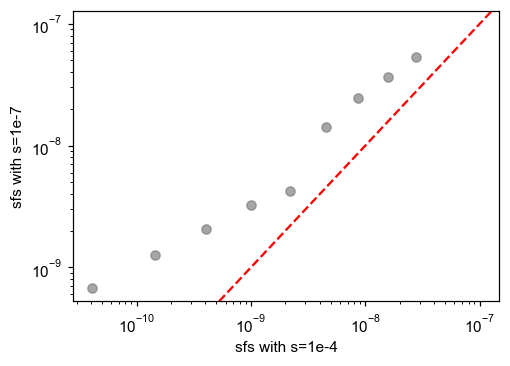

In [155]:
plt.scatter(mom[100,:], mom2[100,:], alpha=0.7, color='grey')
plt.xlabel('sfs with s=1e-4'); plt.ylabel('sfs with s=1e-7'); plt.loglog()
plt.axline((0,0),(1e-7,1e-7),color='red',ls='--')

In [196]:
## creating a database of P(X, a | s) with dicts for different s values
p_xa_s = {}
for g in gamma:
    p_xa_s[g] = run_mom_framework(t=25000, n=10, s=0.5*g/N, N=N, misc=[ibis, jk13])

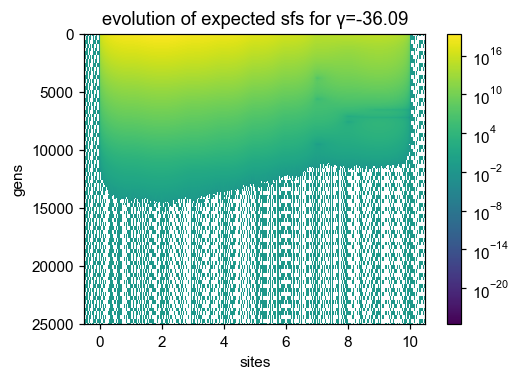

In [203]:
plt.imshow(p_xa_s[gamma[23]],aspect='auto',norm=colors.LogNorm())#vmax=10e-7,vmin=10e-30))
plt.xlabel('# of derived alleles'); plt.ylabel('gens'); 
plt.title('evolution of expected sfs for γ={:.2f}'.format(gamma[23])); plt.colorbar()